# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

In [39]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = False


def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return



(600, 800)

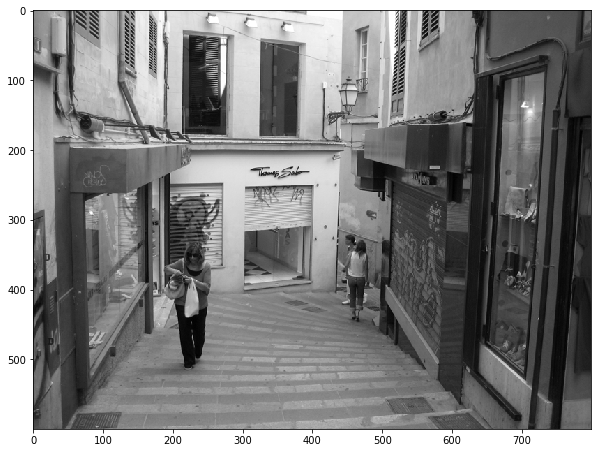

In [40]:
file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper, 0 or 1) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixel values to the range $(0,1)$ (np.clip).

In [41]:
def add_gaussian_noise(img_in,sigma_noise):

    # FILL IN CODE
    gaussian_noise = np.random.normal(0, sigma_noise, size=(img_in.shape))
    img_out = np.clip(img_in + gaussian_noise, 0, 1)
    return img_out

# we define the impulse probability p as the probability of a pixel not being affected
def add_impulse_noise(img_in,p=0.9):
    # FILL IN CODE
    img_out = img_in.copy()
    for i in range(img_in.shape[0]):
        for j in range(img_in.shape[1]):
            if np.random.binomial(1,p,1)[0] != 1:
                if np.random.binomial(1,0.5,1)[0] == 0:
                    img_out[i, j] = 0 
                else :
                    img_out[i, j] = 1
    return img_out

def add_missing_pixels_noise(img_in,p=0.9):
    # FILL IN CODE
    img_out = img_in.copy()
    for i in range(img_in.shape[0]):
        for j in range(img_in.shape[1]):
            if np.random.binomial(1,p,1)[0] == 0:
                img_out[i, j] = 0
    return img_out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$, the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [42]:
sigma_noise = 0.05
img_gray_gaussian = add_gaussian_noise(img_gray, sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

img_gray_impulse = add_impulse_noise(img_gray, 0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')

img_gray_missing = add_missing_pixels_noise(img_gray, 0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question__ For each type of noise, propose a restoration filter (see course slides).

__Answer__ As presented in the slides here are the restoration filter for each type of noise : 
* Gaussian noise can be removed using a smoothing filter (or Gaussian filter)
* As with the impulse noise and the (random) missing pixels, only a few pixels are damaged, we can restore the image using the median filter for both

Implement these restoration filters in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__IMPORTANT NOTE__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented (do not re-implement the filters)

In [43]:
from scipy.ndimage.filters import gaussian_filter, median_filter

# FILL IN CODE : CREATE THE FUNCTIONS TO CARRY OUT THE RESTORATION FILTERS AND WRITE THE RESULTS
img_gray_gaussian_r = gaussian_filter(img_gray_gaussian, sigma = 0.9)
img_gray_impulse_r = median_filter(img_gray_impulse, size = 3)
img_gray_missing_r = median_filter(img_gray_missing, size = 3)

write_image(img_gray_gaussian_r, file_name + '_gaussian_restored.png')
write_image(img_gray_impulse_r, file_name + '_impulse_restored.png')
write_image(img_gray_missing_r, file_name + '_missing_restored.png')

__Question__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__ Roughly speaking, 
* For the Gaussian filter, we are trying to find a tradeoff in blurring the image (increase the value of sigma). Indeed, blurring enables to smooth the noise introduced in pixels. Thus, if we don't have a value of sigma which is high enough, we don't smooth the noisy picture and the filter is useless. On the contrary, if we set a too high sigma value, the filtered image is too blurry.
* For the median filter (impulse noise and missing pixels), we are trying to find a tradeoff in the size of the region we consider around a pixel to take its median value and affect it to the pixel. Indeed, if we don't consider a large enough region, some pixel are not restored and if it is too large then the elements (regions) of the image "overlap", they are not distinguishable from one another

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only (first filter)__. 

In [44]:
def PSNR(img,img_ref):
    # FILL IN CODE
    sum = 0 
    img = img.astype(np.float64) / 255.
    img_ref = img_ref.astype(np.float64) / 255.
    mse = np.mean((img_ref - img) ** 2)
    psnr = -10 * np.log(mse)
    return psnr

# FILL IN CODE : TEST THE PSNR FOR SEVERAL VALUES OF SIGMA
def PSNR_test(img_in, sigma):
    img_gray_gaussian = add_gaussian_noise(img_in, sigma)
    img_gray_gaussian_r = gaussian_filter(img_gray_gaussian, sigma = sigma)
    psnr = PSNR(img_gray_gaussian_r, img_gray_gaussian)
    return psnr

In [47]:
for sigma in [0.01, 0.1, 0.5, 1, 2, 5]:
    psnr = PSNR_test(img_gray, sigma)
    print("With sigma = ", sigma)
    print("We have PSNR = ",psnr)

With sigma =  0.01
We have PSNR =  inf
With sigma =  0.1
We have PSNR =  inf
With sigma =  0.5
We have PSNR =  149.82627245482723
With sigma =  1
We have PSNR =  130.74227398992147
With sigma =  2
We have PSNR =  126.80236499467316
With sigma =  5
We have PSNR =  125.34492104834479


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


## FUTHER RESTORATION TECHNIQUES (THIS IS NOT OBLIGATORY)

## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


(600, 600)

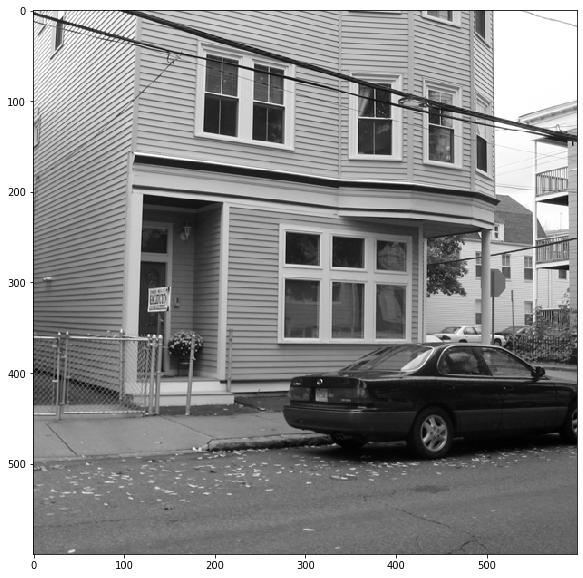

In [38]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

In [ ]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ (in the Fourier domain, so using $\hat{f}$) and write the result ``img_convolved`` to an output file

__Question__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ?
 How can this happen in real life ? 

In [ ]:
img_convolved = # FILL IN CODE

img_convolved -= img_convolved.min()
img_convolved /= img_convolved.max()

write_image(img_convolved,file_name+'_convolution.png')
img_convolved.max()

__Answer__ 

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue.


In [ ]:
def deconvolve_fourier(img,f_hat):
    # FILL IN CODE
    return img_out
    

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')